#This Code is done by Joydav Banik
#Project: MPHASIS-LTTS Pair Trading
#Feel free to reach out : joydavbanik@gmail.com or https://www.linkedin.com/in/joydav-banik

##What is Pair Trading?
-> Pair trading is a market-neutral strategy that involves matching a long position with a short position in two highly correlated instruments—typically stocks, ETFs, or indices. The core idea is to exploit temporary divergences in price relationships while hedging market risk.

##How It Works
Identify a Pair: Choose two assets that historically move together (high correlation).

Monitor the Spread: Track the price difference (or ratio) between the two.

Enter the Trade:

Go long on the undervalued asset.

Go short on the overvalued asset.

Exit the Trade:

When the spread reverts to the mean, close both positions for a profit.

##Key Concepts:
Hedge Ratio: Ensures proper position sizing to maintain neutrality.

Cointegration: A stronger statistical relationship than correlation, often used in more advanced models.

Market-neutral: Reduces exposure to overall market movement.

Statistical foundation: Uses quantitative methods for entries/exits.

Works in sideways markets: Profit from relative price changes, not overall direction.

In [1]:
#IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
#DATE
enddate = datetime.datetime.today()
startdate = enddate - datetime.timedelta(days=3650)

In [3]:
#DATA DOWNLOAD from Yahoo Finance's API
#10 years of data
MPHASIS = yf.download('MPHASIS.NS', start=startdate, end=enddate,interval='1D')['Close']
LTTS = yf.download('LTTS.NS', start=startdate, end=enddate,interval='1D')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#DATAFRAME CHECK
MPHASIS

Ticker,MPHASIS.NS
Date,
2015-04-20,297.514252
2015-04-21,301.050659
2015-04-22,297.095978
2015-04-23,300.746490
2015-04-24,296.107300
...,...
2025-04-04,2229.199951
2025-04-07,2102.199951
2025-04-08,2168.899902


In [5]:
#DATAFRAME CHECK
LTTS

Ticker,LTTS.NS
Date,
2016-09-23,791.198975
2016-09-26,792.701233
2016-09-27,784.506897
2016-09-28,786.191345
2016-09-29,770.167236
...,...
2025-04-07,4083.600098
2025-04-08,4102.149902
2025-04-09,4089.550049


In [6]:
pair = pd.concat([MPHASIS, LTTS], axis=1)
pair.columns =['MPHASIS','LTTS']
pair.index = pd.to_datetime(pair.index, yearfirst=True)
pair.dropna
pair.shape
pair

,MPHASIS,LTTS
Date,,
2015-04-20,297.514252,NaN
2015-04-21,301.050659,NaN
2015-04-22,297.095978,NaN
2015-04-23,300.746490,NaN
2015-04-24,296.107300,NaN
...,...,...
2025-04-07,2102.199951,4083.600098
2025-04-08,2168.899902,4102.149902
2025-04-09,2117.600098,4089.550049


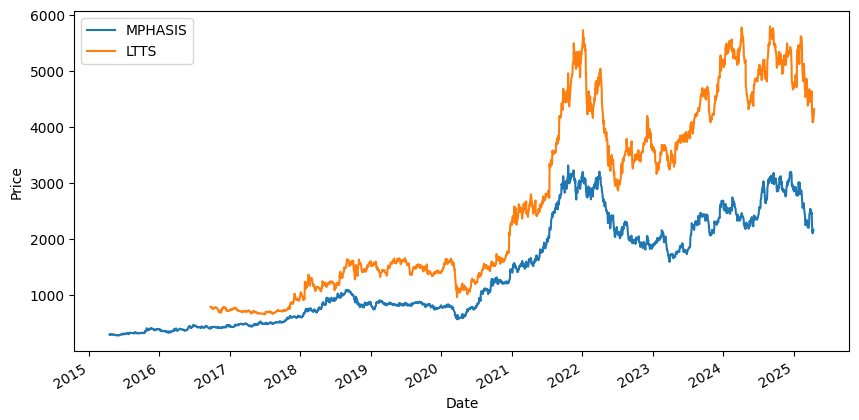

In [7]:
pair.plot(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [8]:
#HEDGE RATIO FIND
pair = pair.replace([np.inf, -np.inf], np.nan).dropna()

model = sm.OLS(pair.MPHASIS.iloc[:30], pair.LTTS.iloc[:30])
model = model.fit()
print('The hedge ratio is %.2f' % model.params.iloc[0])

The hedge ratio is 0.56


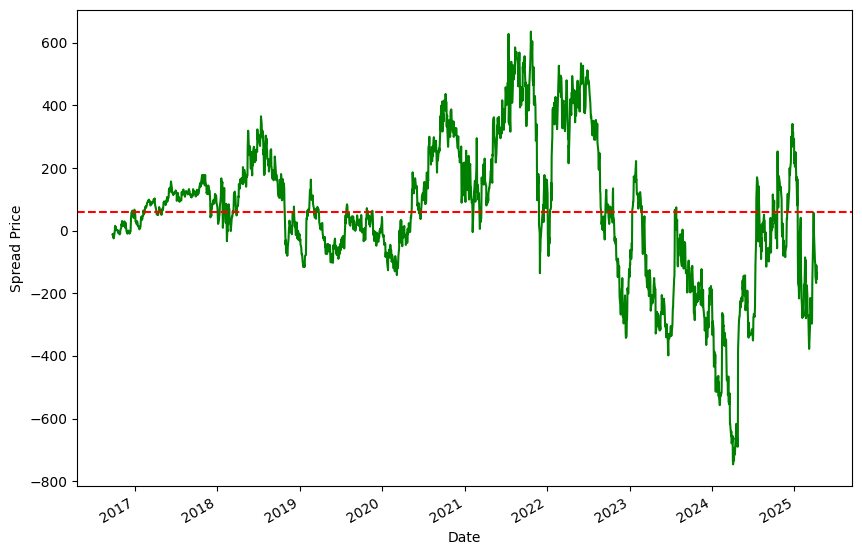

In [9]:
#Calculating and plotting the spread between 'MPHASIS' and 'LTTS' prices, adjusted by the hedge ratio. This spread visualization aids in identifying trading opportunities based on price differentials.
pair['Spread'] = pair.MPHASIS - model.params.iloc[0] * pair.LTTS

pair.Spread.plot(figsize=(10,7),color='g')
plt.xlabel('Date')
plt.ylabel('Spread Price')
plt.axhline(pair.Spread.mean(), color='r', linestyle='--')
plt.show()

#Cointegration
##Cointegration is a unique form of correlation between two time series, where their ratio fluctuates around a mean value. In pairs trading, cointegration is essential as it ensures the ratio between assets converges to a stable mean over time, validating the strategy's effectiveness.


#Testing for Cointegration
####In the statsmodels.tsa.stattools library, there's a convenient test for cointegration. Given that we've artificially constructed two highly cointegrated series, we expect to observe an extremely low p-value from this test.



In [10]:
#Using the Augmented Dickey-Fuller (ADF) test from statsmodels.tsa.stattools to assess the stationarity of the 'spread' series. A low p-value indicates strong evidence against non-stationarity, validating its suitability for pairs trading strategies.
#performing ADF Test

# Importing the ADF test function from statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
result = adfuller(pair.Spread, maxlag=1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f', result[1])
print('Critical Values:',result[4])

# Check if the spread series is stationary based on the p-value
if result[1] < 0.05:
    print("The spread series is likely stationary.")
else:
    print("The spread series is likely not stationary.")

ADF Statistic: -3.475257
p-value: %f 0.008645762672756586
Critical Values: {'1%': np.float64(-3.433452973124137), '5%': np.float64(-2.862910765700749), '10%': np.float64(-2.5674997304642755)}
The spread series is likely stationary.


#Spread-based Mean Reversion Strategy Function
##This function calculates trading positions based on the spread, incorporating parameters such as the lookback period and standard deviation. It enables the implementation of a mean reversion trading strategy.



In [11]:
import numpy as np
import pandas as pd

def mean_reversion_strategy(pair, period, std_dev):
    """
    Implements a mean reversion trading strategy on a spread series.

    Parameters:
    - pair (DataFrame): Must include a 'Spread' column representing the price spread between two assets.
    - period (int): Lookback period for moving average and standard deviation.
    - std_dev (float): Multiplier for standard deviation to define trading bands.

    Returns:
    - pair (DataFrame): Original DataFrame with added columns for moving averages, bands, and position signals.
    """

    # Calculate moving average and standard deviation
    pair['moving_average'] = pair['Spread'].rolling(window=period).mean()
    pair['moving_std_dev'] = pair['Spread'].rolling(window=period).std()

    # Define upper and lower bands
    pair['upper_band'] = pair['moving_average'] + std_dev * pair['moving_std_dev']
    pair['lower_band'] = pair['moving_average'] - std_dev * pair['moving_std_dev']

    # Entry and exit conditions for long positions
    pair['long_entry'] = pair['Spread'] < pair['lower_band']
    pair['long_exit'] = pair['Spread'] >= pair['moving_average']
    pair['positions_long'] = np.nan
    pair.loc[pair['long_entry'], 'positions_long'] = 1
    pair.loc[pair['long_exit'], 'positions_long'] = 0
    pair['positions_long'] = pair['positions_long'].ffill()

    # Entry and exit conditions for short positions
    pair['short_entry'] = pair['Spread'] > pair['upper_band']
    pair['short_exit'] = pair['Spread'] <= pair['moving_average']
    pair['positions_short'] = np.nan
    pair.loc[pair['short_entry'], 'positions_short'] = -1
    pair.loc[pair['short_exit'], 'positions_short'] = 0
    pair['positions_short'] = pair['positions_short'].ffill()

    # Combine both long and short positions into a single signal
    pair['positions'] = pair['positions_long'] + pair['positions_short']

    return pair

In [12]:
pair = mean_reversion_strategy(pair,30,2)
pair.dropna(inplace=True)
pair

,MPHASIS,LTTS,Spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions
Date,,,,,,,,,,,,,,
2016-11-22,419.950195,742.944641,7.066129,9.136549,14.084443,37.305435,-19.032338,False,False,0.0,False,True,0.0,0.0
2016-11-23,418.759216,741.756775,6.535295,9.177564,14.074688,37.326940,-18.971813,False,False,0.0,False,True,0.0,0.0
2016-11-24,419.169830,758.571228,-2.398556,8.722552,14.225162,37.172876,-19.727772,False,False,0.0,False,True,0.0,0.0
2016-11-25,427.342957,777.122070,-4.534875,8.532064,14.367203,37.266469,-20.202341,False,False,0.0,False,True,0.0,0.0
2016-11-28,420.812683,774.791504,-9.769959,8.156044,14.701045,37.558134,-21.246047,False,False,0.0,False,True,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-04,2229.199951,4274.200195,-146.144131,-193.825723,117.747560,41.669397,-429.320843,False,True,0.0,False,False,-1.0,-1.0
2025-04-07,2102.199951,4083.600098,-167.220030,-196.188289,116.427821,36.667352,-429.043931,False,True,0.0,False,False,-1.0,-1.0
2025-04-08,2168.899902,4102.149902,-110.828947,-196.734774,115.971324,35.207875,-428.677422,False,True,0.0,False,False,-1.0,-1.0


#Cumulative Return

In [13]:
model
pair['percentage_change'] = (pair.Spread - pair.Spread.shift(1))/(model.params.iloc[0]*pair.LTTS + pair.MPHASIS)
pair['strategy_returns'] = pair.positions.shift(1) * pair.percentage_change
pair['cumulative_returns'] = (pair.strategy_returns + 1).cumprod()
print("The total strategy returns are %.2f" % ((pair['cumulative_returns'].iloc[-1]-1)*100))

The total strategy returns are 93.96


#Sharpe Ratio

In [14]:
# Calculating the Sharpe ratio of the strategy
sharpe_ratio = (pair['strategy_returns'].mean() * 252) / (pair['strategy_returns'].std() * np.sqrt(252))

# Printing the Sharpe ratio with 3 decimal places
print(f'Sharpe Ratio: {np.round(sharpe_ratio, 3)}')

Sharpe Ratio: 0.652


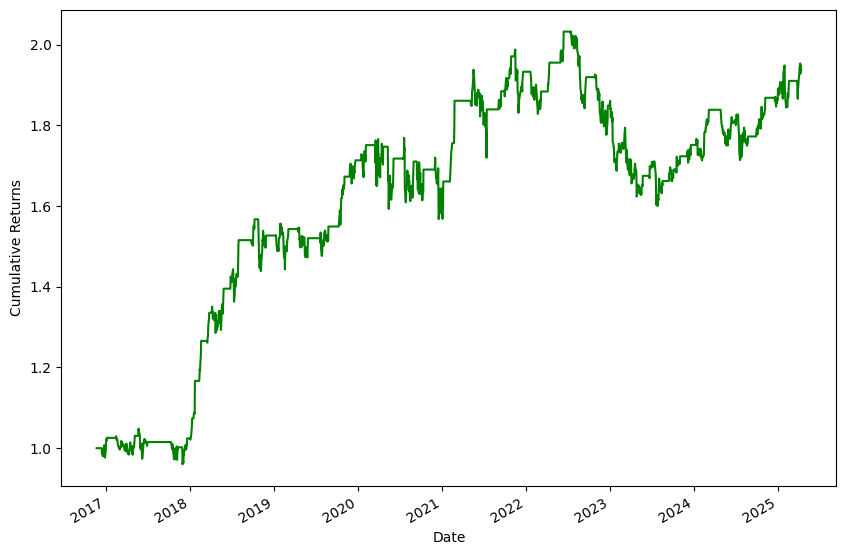

In [15]:
#plotting the cumulative returns of the strategy
pair.cumulative_returns.plot(label='Returns', figsize=(10,7),color='green')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

#Drawdown Function

The maximum drawdown is -21.28%


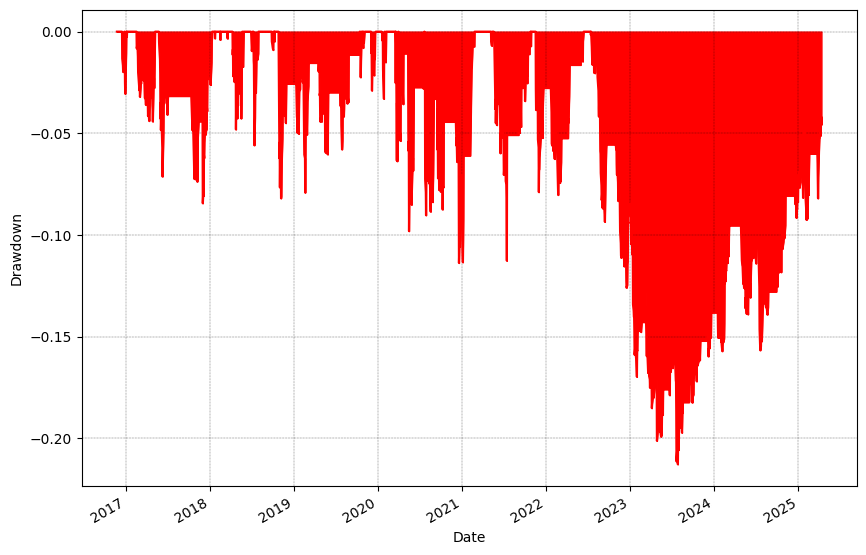

In [21]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Drawdown')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

drawdown_strategy = calc_drawdown(pair.cumulative_returns)
print("The maximum drawdown is %.2f%%" % (drawdown_strategy.min().item()* 100))

plot_drawdown(drawdown_strategy)

[*********************100%***********************]  1 of 1 completed


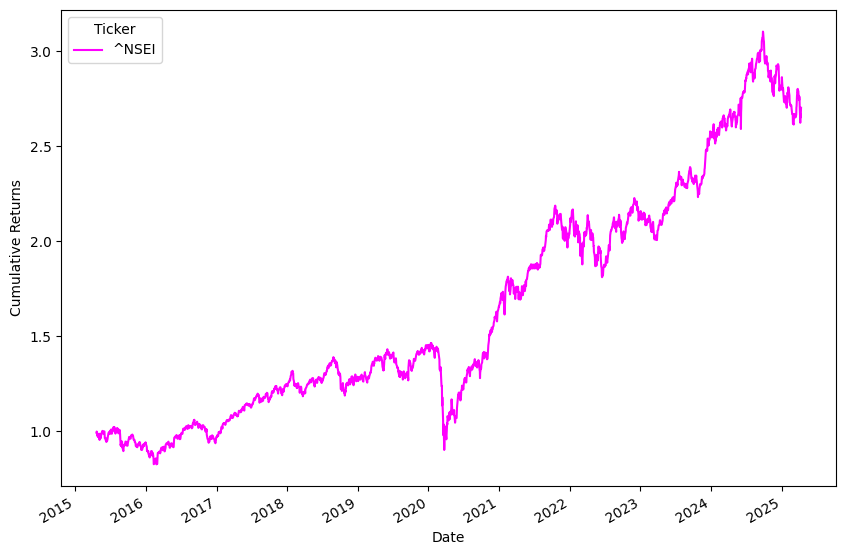

Ticker,^NSEI
Date,
2015-04-20,8448.099609
2015-04-21,8377.750000
2015-04-22,8429.700195
2015-04-23,8398.299805
2015-04-24,8305.250000
...,...
2025-04-04,22904.449219
2025-04-07,22161.599609
2025-04-08,22535.849609


In [22]:
#to compare how our strategy performed , we will create an instance and compare the drawdown
Nifty = yf.download('^NSEI', start=startdate, end=enddate,interval='1D')['Close']
Nifty_cum_rets = (Nifty.pct_change().dropna()+1).cumprod()
Nifty_cum_rets.plot(label='Nifty', figsize=(10,7),color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()
Nifty

In [25]:
#drawdown_nifty
drawdown_Nifty = calc_drawdown(Nifty_cum_rets)
print("The maximum drawdown is %.2f%%" % (drawdown_Nifty.min()*100))

The maximum drawdown is -38.44%


In [27]:
# Calculate the number of years from the data
days = (pair.index[-1] - pair.index[0]).days
years = days / 365

pair = pair.dropna(subset=['cumulative_returns'])
initial_value = pair['cumulative_returns'].iloc[0]
final_value = pair['cumulative_returns'].iloc[-1]
years = 9.616438356164384

cagr = (final_value / initial_value) ** (1 / years) - 1
print(f"CAGR: {cagr:.3%}")

CAGR: 7.132%
